In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
#from lib.models import FcNN, MyFCNNActorProb, MyFCNNActorProb2, MyFcnnActor, MyCritc, Backbone
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [3]:
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
                  99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
                  160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]

train_seeds = seeds[:30]
val_seeds = seeds[30:]
test_seeds = np.array([69, 33, 420])

print(train_seeds)
print(val_seeds)

[102 348 270 106  71 188  20 121 214 330  87 372  99 359 151 130 149 308
 257 343 413 293 385 191 276 160 313  21 252 235]
[344  42]


# iterate through all seeds and print intial voriticity in a grid

In [ ]:
vorts = np.zeros((seeds.shape[0], 128,128))
for i in range(seeds.shape[0]):
    env = KolmogorovEnvironment6(seeds=np.array([seeds[i]]))
    vorts[i,...] = env.get_vorticity()
    env.close()


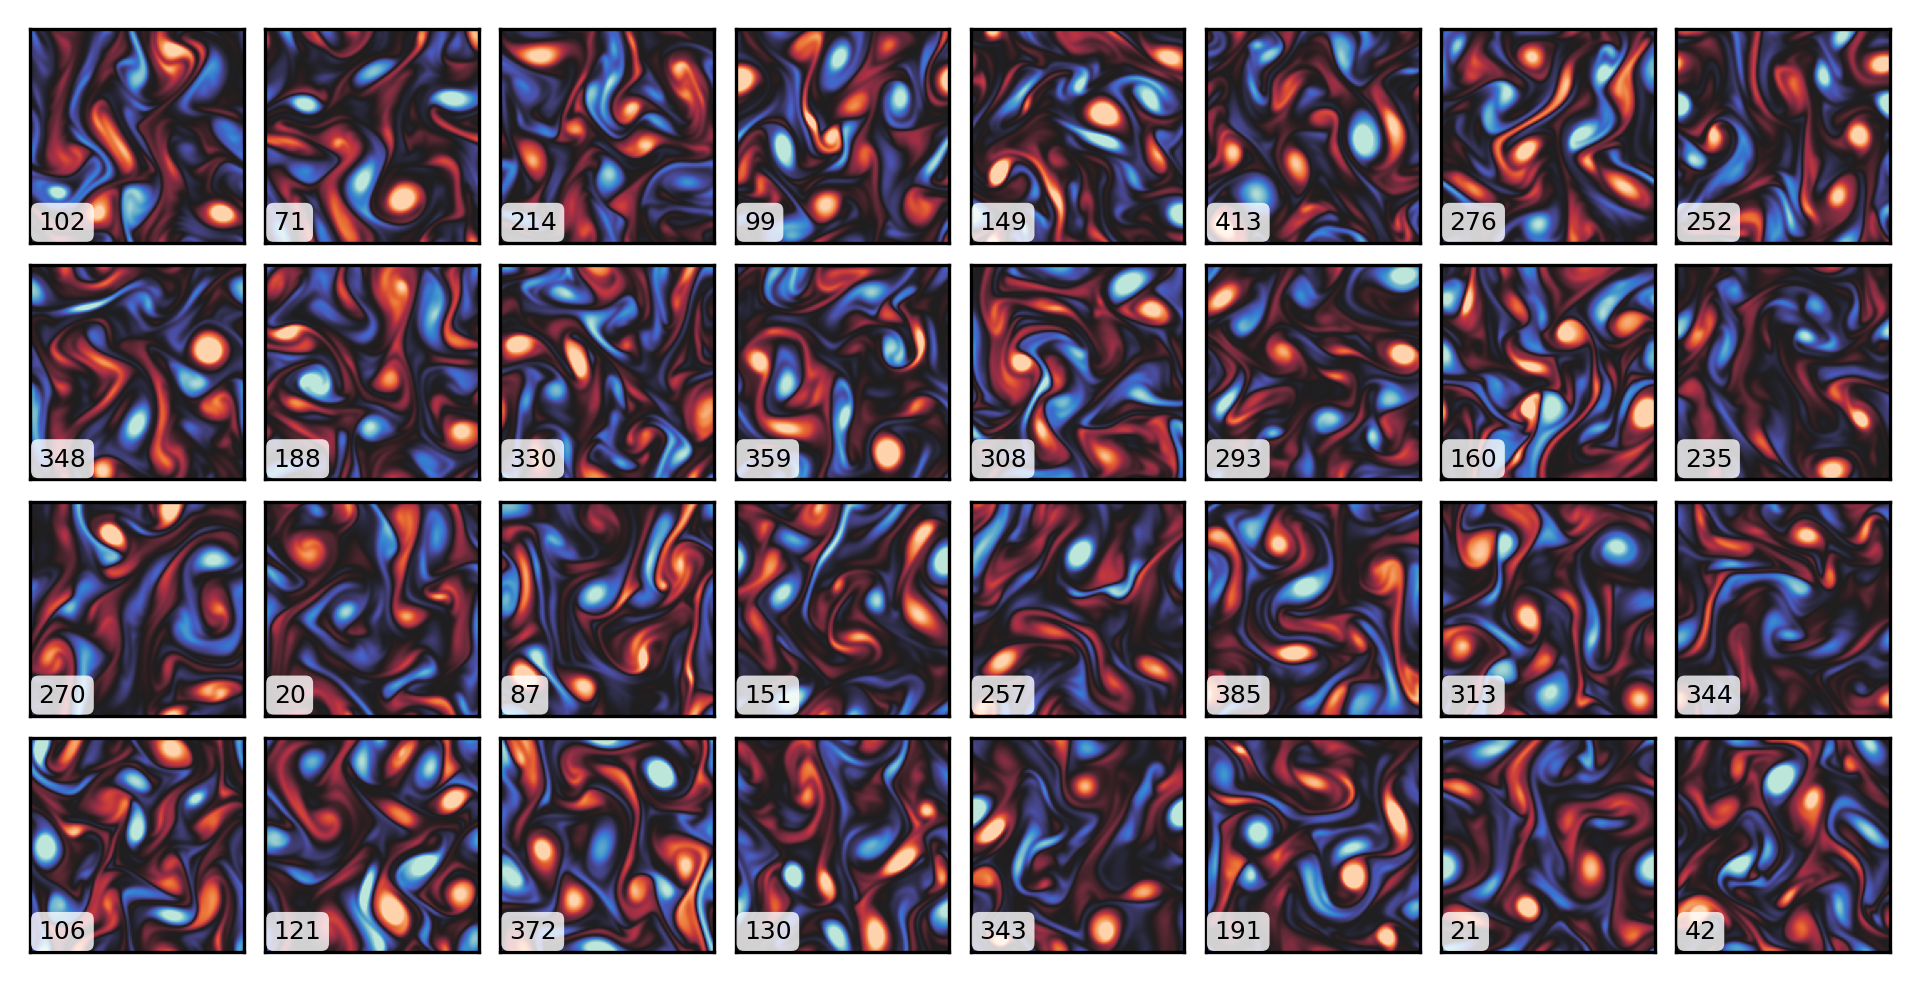

In [ ]:
# plot vorticity images at times t1 to t5 for all resolutions
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.8)
fig, axs = plt.subplots(4, 8, figsize=(8,4), dpi=300)
# add tight layout
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(8):
    for j in range(4):     
        axs[j, i].imshow(vorts[4*i+j], vmin=-12, vmax=12, cmap=sn.cm.icefire)
        #axs[j, i].axis('off')
        # disable ticks 
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].text(0.04, 0.04, f"{seeds[4*i+j]}", ha='left', va='bottom', fontsize=6, color='black', bbox=bbox_props, transform=axs[j,i].transAxes)
plt.show()

# plot energy spectrum over the coarse of a simulation between fgs and cgs

In [4]:
env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=1536-1, step_factor=1)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


0 0
Correlation: 0.9991326297480867
MSE: 8.389118945742234e-05
NMSE: 8.060004477498618e-05
pointwise relative mse: 1.0171380309686808


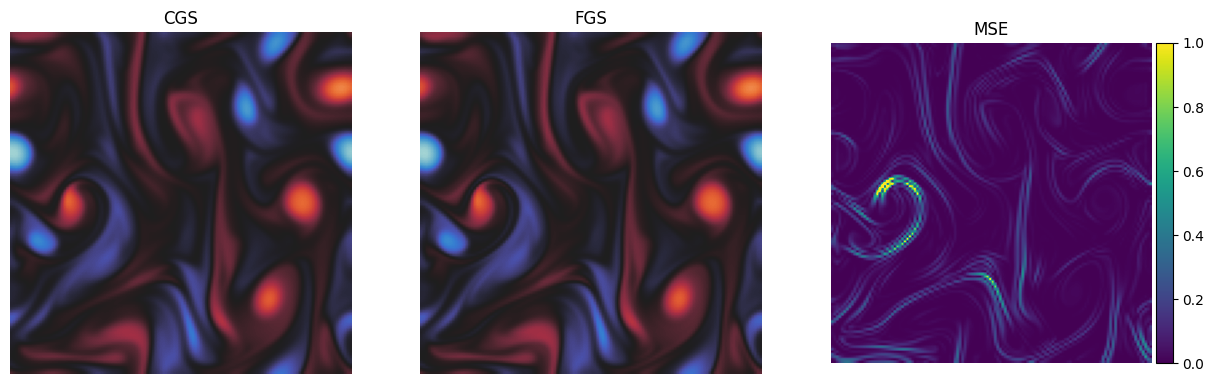

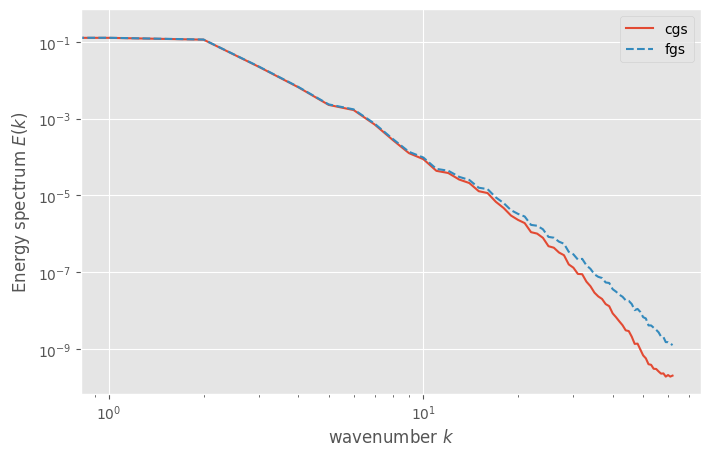

200 -0.7683228227189574
Correlation: 0.9899498983925331
MSE: 0.0017278398002813595
NMSE: 0.0016645731190159747
pointwise relative mse: 7.081220723886739


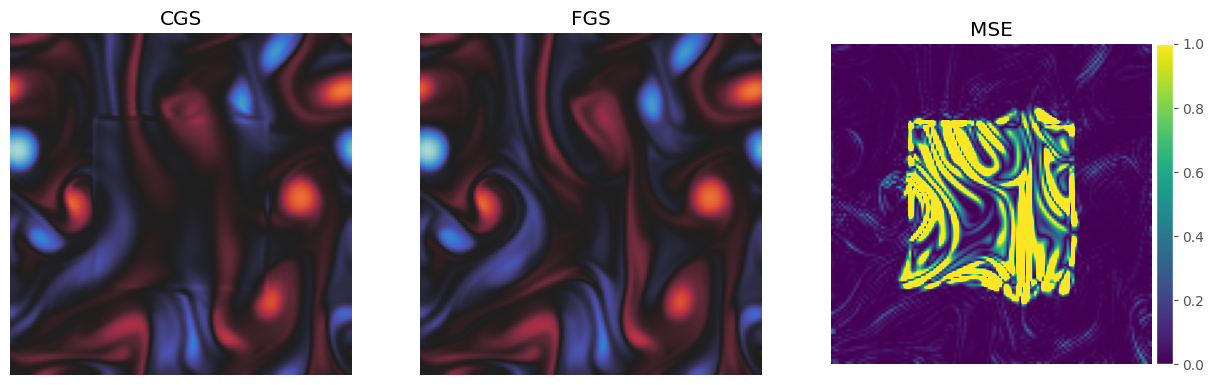

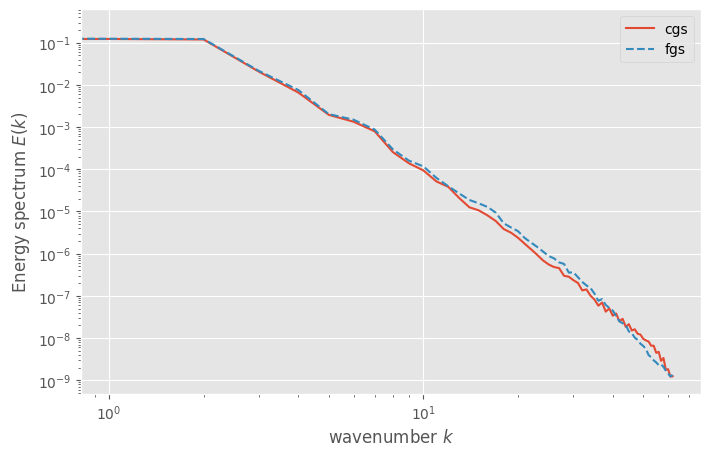

400 -0.9943211295144181
Correlation: 0.983522951753881
MSE: 0.004251786987393737
NMSE: 0.004113598729605161
pointwise relative mse: 25.42085819926624


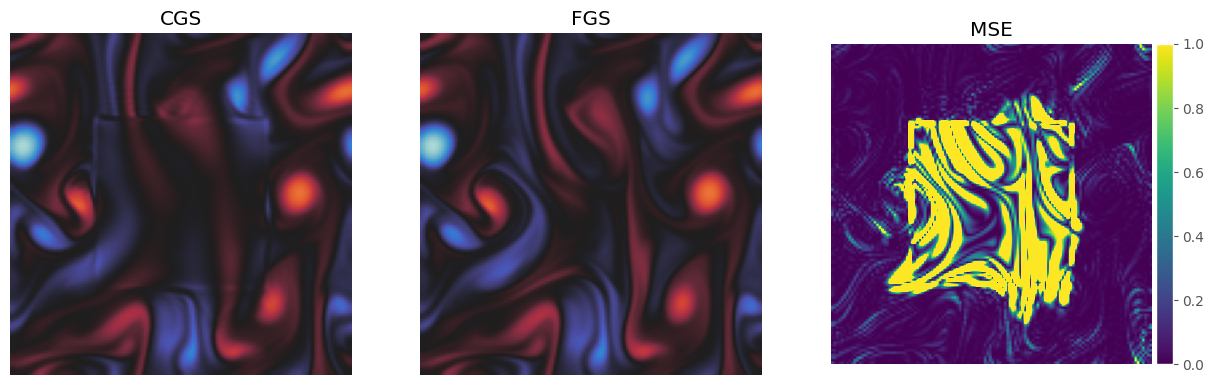

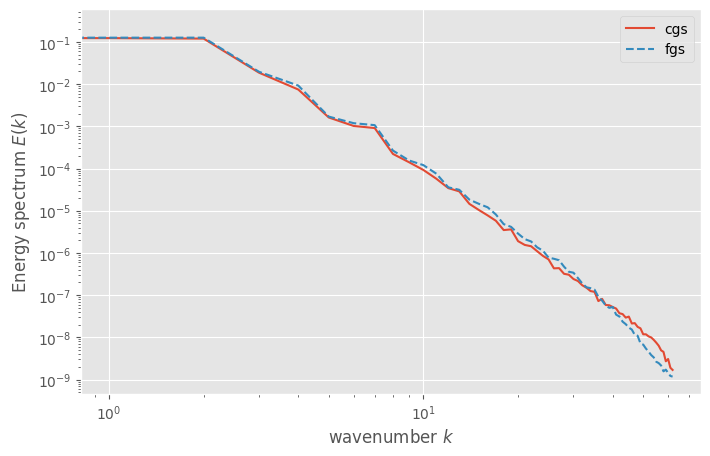

600 -1.1485728130200528
Correlation: 0.9773406461816534
MSE: 0.0073041442185312454
NMSE: 0.007109715326537871
pointwise relative mse: 46976.07699756575


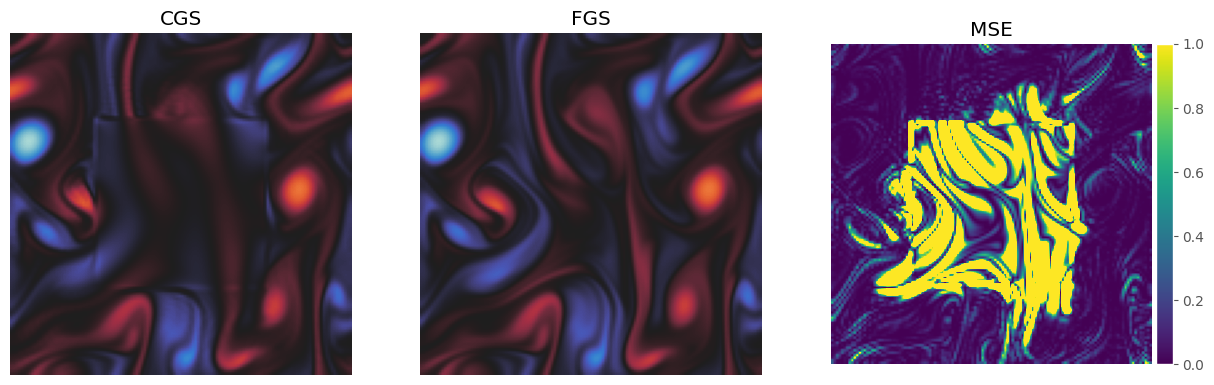

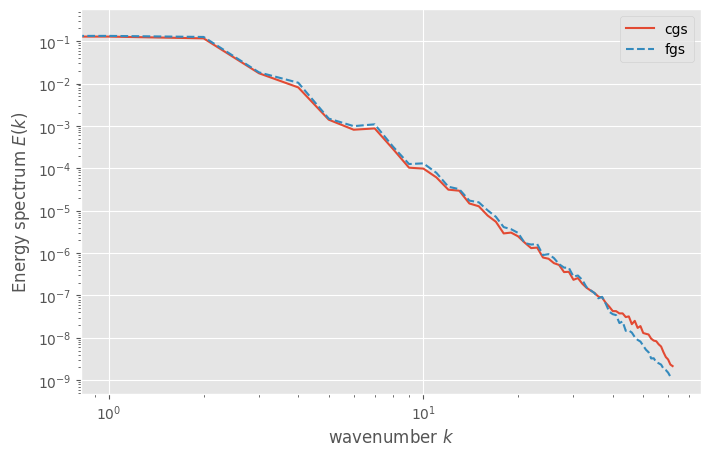

terminated
#steps = 791, Total Reward = -734.9295410937907
Execution time: 5.275259494781494 seconds


In [6]:
import time
#time one klmgrv5 episode
start_time = time.time()
reward = 0
step = 0
act = np.ones(env.action_space.shape)
act[32:96, 32:96] = 0.92
obs ,inf = env.reset()
rew = 0
episode_is_over = False
while not episode_is_over:
    if step%200==0:
        print(step, rew)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()

        #plot enerty spectra
        E1, E2 = env.get_spectra()
        plt.style.use('ggplot')
        plt.figure(figsize=(8, 5), dpi=100)
        plt.loglog(E1, label='cgs')
        plt.loglog(E2, linestyle='dashed', label='fgs')
        plt.ylabel(r'Energy spectrum $E(k)$')
        plt.xlabel(r'wavenumber $k$')
        plt.legend()
        plt.show()

    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True



print(f"#steps = {step}, Total Reward = {reward}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [ ]:
# TODO: think of other statistics that could be used